In [ ]:
#| default_exp GEMlearn

# GEMdataset

> This package will hold the GxExM dataset.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
#| hide
from hybridpredictmaize22.GEMdataset import *

In [ ]:
#| export
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

from tqdm import tqdm
from torch.utils.data import DataLoader


#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

from fastprogress import progress_bar,master_bar
from torcheval.metrics import MeanSquaredError,Mean, R2Score


In [ ]:
#| hide
def remove_leapdays(weather):
    """ just a hotfix """
    to_remove = []
    for i in list(set(weather_data['Env'])):
        if (sum(weather_data['Env'] == i)) == 366:
            #get indexes
            to_remove.append(max(list(weather_data.loc[weather_data['Env'] == i].index)))
    return weather_data.drop(to_remove)

In [ ]:
ARGS = {
'test_split':2019,
'path_snps':Path('data/snpCompress/'),
'data_path':Path('data/'),
'path_train_weatherTable':Path('data/Training_Data/4_Training_Weather_Data_2014_2021.csv'),
'path_train_yieldTable':Path('data/Training_Data/1_Training_Trait_Data_2014_2021.csv'),
'snp_compression':'PCS_50',
'batch_size':64
}

In [ ]:
test_split = 2019
path_snps = Path('data/snpCompress/')
data_path = Path('data/')
path_train_weatherTable =data_path/'Training_Data/4_Training_Weather_Data_2014_2021.csv'
path_train_yieldTable = data_path/'Training_Data/1_Training_Trait_Data_2014_2021.csv'
snp_compression = 'PCS_50'
batch_size = 1

def setup_data():
    
    snp_data = collect_snps(path_snps/snp_compression) # Read in the SNP profiles
    yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
    weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
    
    yield_data = yield_data[yield_data['Yield_Mg_ha'].notnull()] #Remove plots w/ missing yields
    #yield_data = yield_data.reset_index()
    weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
    #removes yield data where no weather data
    setYield = set(yield_data['Env'])
    setWeather = set(weather_data['Env'])
    only_yield = setYield - setWeather
    only_weather = setWeather - setYield
    yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
    #removes yield data where no genotype data
    setSNP = set(snp_data[0])
    setYield = set(yield_data['Hybrid'])
    only_yield = setYield - setSNP
    yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

    weather_data = remove_leapdays(weather_data)
    #weather_data = weather_data.reset_index()
    #yield_data=yield_data.sample(frac=1)
    yield_data = yield_data.reset_index()
    
    #Create a GEM dataset
    gem = GEM(test_split)
    gem.Y = YT(yield_data, test_split)
    gem.W = WT(weather_data, test_split)
    gem.SNP = snp_data
    
    tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
    te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)
    
    tr_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
    te_dataloader = DataLoader(te_ds, batch_size=batch_size, shuffle=False)
    
    return tr_dataloader, te_dataloader

In [ ]:
snp_data = collect_snps(path_snps/snp_compression) # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data[yield_data['Yield_Mg_ha'].notnull()] #Remove plots w/ missing yields
weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

weather_data = remove_leapdays(weather_data)
weather_data = weather_data.reset_index()
yield_data=yield_data.sample(frac=1)
yield_data = yield_data.reset_index()

In [ ]:
#df.drop('column_name', axis=1, inplace=True)

yield_data.drop('index',axis=1, inplace=True)

In [ ]:
batch_size=64

#Create a GEM dataset
gem = GEM(test_split)

gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_data

tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

tr_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
te_dataloader = DataLoader(te_ds, batch_size=batch_size, shuffle=True)

dls = (tr_dataloader, te_dataloader)


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Create a list of linear layers, with the correct input and output dimensions
        self.layers = torch.nn.ModuleList([torch.nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers - 1)])
        self.layers.append(torch.nn.Linear(hidden_dim, output_dim))

        # Initialize the weights and biases of the linear layers using the Xavier initialization method
        for layer in self.layers:
            torch.nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Apply the dropout layer to the input
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        # Iterate through the linear layers, applying each one to the input
        for layer in self.layers:
            x = layer(x)
            x = torch.nn.functional.relu(x)
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        return x

In [ ]:
losses = []
predslist = []
model = MLP(500,50,1, num_layers=5)
opt = torch.optim.SGD(model.parameters(), lr=.01)
loss_func = F.mse_loss
for _ in range(1):
    for c, (y,g,w) in tqdm(enumerate(tr_dataloader)):
        g = g.type(torch.float32)
        w = w.type(torch.float32)
        preds = model(g)
        if preds[0].isnan():
            print('----------')
            print('y',y)
            print('g',g)
            print('w',w)
            print('p', preds)
            print('stop')
            break
        y = y.type(torch.float32)
        preds= preds.squeeze()
        predslist.append(preds.detach().numpy())
        loss = loss_func(preds,y.squeeze())
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss.detach().numpy())
        if c > 1000:
            print(c)
            break

1001it [04:08,  4.03it/s]

1001


(array([ 1.,  0.,  1.,  3.,  1.,  2.,  4., 11., 14., 17., 19., 22., 32.,
        19., 30., 35., 45., 50., 44., 62., 46., 46., 46., 49., 38., 46.,
        37., 41., 32., 38., 38., 19., 20., 17., 18.,  9.,  9.,  8.,  2.,
        10.,  7.,  3.,  1.,  2.,  1.,  3.,  1.,  0.,  1.,  2.]),
 array([0.4888756 , 0.51157963, 0.53428364, 0.5569877 , 0.57969171,
        0.60239577, 0.62509978, 0.64780384, 0.67050785, 0.69321191,
        0.71591592, 0.73861992, 0.76132399, 0.78402799, 0.80673206,
        0.82943606, 0.85214013, 0.87484413, 0.8975482 , 0.9202522 ,
        0.94295621, 0.96566027, 0.98836428, 1.01106834, 1.03377235,
        1.05647635, 1.07918048, 1.10188448, 1.12458849, 1.14729249,
        1.1699965 , 1.19270062, 1.21540463, 1.23810863, 1.26081264,
        1.28351676, 1.30622077, 1.32892478, 1.35162878, 1.3743329 ,
        1.39703691, 1.41974092, 1.44244492, 1.46514893, 1.48785305,
        1.51055706, 1.53326106, 1.55596507, 1.57866919, 1.6013732 ,
        1.6240772 ]),
 <BarContainer

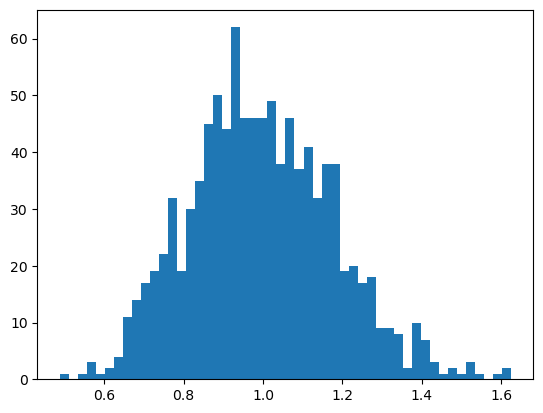

In [ ]:
plt.hist(losses,bins = 50)

In [ ]:
samps = []

for _ in range(5):
    yield_set = gem.Y.Tr.iloc[:1000,:]
    avg_yield = np.mean(yield_set['scaled_yield'])
    model = MLP(input_size=100, hidden_size=64, output_size=1)



    envs = list(yield_set['Env'])
    hybrids = list(yield_set['Hybrid'])
    y = np.array(list(yield_set['scaled_yield']))
    snp_idx = []
    for i in hybrids:
        snp_idx.append(np.where(gem.SNP[0]==i)[0][0])
    g = gem.SNP[1][:,snp_idx]

    w = []
    for i in envs:
        x = gem.W.Tr[gem.W.Tr['Env'] == i]
        w.append(np.array(x.iloc[:365,:].select_dtypes('float')))
    w=np.array(w)


    g = torch.tensor(g.reshape(yield_set.shape[0],100)).type(torch.float32)
    preds = model(g)
    d = F.mse_loss(preds,torch.tensor(y).unsqueeze(axis=1).type(torch.float32))
    samps.append(d.detach().numpy())

In [ ]:
g = torch.tensor(g.reshape(yield_set.shape[0],100)).type(torch.float32)
preds = model(g)
F.mse_loss(preds,torch.tensor(y).unsqueeze(axis=1).type(torch.float32))

In [ ]:
# just G

yield_set = gem.Y.Tr.iloc[:1000,:]

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

loss_runs = []
for _ in range(10):
    losses = []
    yield_set = gem.Y.Tr.sample(1000)
    avg_yield = np.mean(yield_set['scaled_yield'])
    model = MLP(input_size=100, hidden_size=200, output_size=1)
    opt = torch.optim.SGD(model.parameters(),lr=.05)
    for _ in tqdm(range(20)):
        samples = yield_set.sample(bs)
        envs = list(samples['Env'])
        hybrids = list(samples['Hybrid'])
        y = np.array(list(samples['scaled_yield']))
        snp_idx = []
        for i in hybrids:
            snp_idx.append(np.where(gem.SNP[0]==i)[0][0])
        g = gem.SNP[1][:,snp_idx]

        w = []
        for i in envs:
            x = gem.W.Tr[gem.W.Tr['Env'] == i]
            w.append(np.array(x.iloc[:365,:].select_dtypes('float')))
        w=np.array(w)

        #train loop
        preds  = model(torch.tensor(g.reshape(5,100)).type(torch.float32))
        loss = F.mse_loss(preds,torch.tensor(y).unsqueeze(axis=1).type(torch.float32))
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss.detach().numpy())
    loss_runs.append(losses)
    
    


In [ ]:
for x in loss_runs:
    plt.plot(running_average(x))
#plt.axhline(y=np.array(avg_yield), color='red', linestyle='-')
plt.title('MLP SNP data only')
plt.show()

In [ ]:
raw_preds = []
for _ in range(1000):
    model = MLP(input_size=100, hidden_size=200, output_size=1)
    samples = yield_set.sample(5)
    preds = model(torch.tensor(g.reshape(5,100)).type(torch.float32))
    for x in [x.detach().numpy() for x in preds]: raw_preds.append(x)

In [ ]:
sum(abs(yield_set['scaled_yield'])) / yield_set.shape[0]

In [ ]:
plt.hist([x[0] for x in raw_preds],bins=20)
plt.title('untrain model predictions')

In [ ]:
gem.Y.plot_yields()

In [ ]:
for x in loss_runs:
    plt.plot(running_average(x))
#plt.axhline(y=np.array(avg_yield), color='red', linestyle='-')
plt.title('MLP SNP data only')
plt.show()

In [ ]:
w.reshape(5,365*16).shape

In [ ]:
# just W

#yield_set = gem.Y.Tr.iloc[:1000,:]

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.fc2(x)
       # x = torch.clip(x,max=1)
        return x

loss_runs = []
for _ in range(4):
    losses = []
    model = MLP(input_size=5840, hidden_size=64, output_size=1)
    opt = torch.optim.SGD(model.parameters(),lr=.1)
    for _ in tqdm(range(250)):
        samples = yield_set.sample(bs)
        envs = list(samples['Env'])
        hybrids = list(samples['Hybrid'])
        y = np.array(list(samples['scaled_yield']))
        snp_idx = []
        for i in hybrids:
            snp_idx.append(np.where(gem.SNP[0]==i)[0][0])
        g = gem.SNP[1][:,snp_idx]

        w = []
        for i in envs:
            x = gem.W.Tr[gem.W.Tr['Env'] == i]
            w.append(np.array(x.iloc[:365,:].select_dtypes('float')))
        w=np.array(w)
        w = w.reshape(5,365*16)
        #train loop
        preds  = model(torch.tensor(w).type(torch.float32))
        loss = F.mse_loss(preds,torch.tensor(y).unsqueeze(axis=1).type(torch.float32))
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss.detach().numpy())
    loss_runs.append(losses)

In [ ]:
for x in loss_runs:
    plt.plot(running_average(x))
plt.show()

In [ ]:
class CNN1D(nn.Module):
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):


In [ ]:
for x in loss_runs:
    plt.plot(running_average(x))
plt.show()

In [ ]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = MLP(input_size=100, hidden_size=64, output_size=1)

In [ ]:
w = [] 
for i in envs:
    x = gem.W.Tr[gem.W.Tr['Env'] == i]
    w.append(np.array(x.iloc[:365,:].select_dtypes('float')))
w=np.array(w)

In [ ]:

class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()

        # Define the layers
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=100, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=200, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=400, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(146000, 100)
        self.fc2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply the layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.relu(x)
        x = x.view(bs,x.shape[1]*x.shape[2])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
cnn = OneDCNN()
wt = torch.tensor(w).type(torch.float32)
wt = wt.reshape(5,16,365)
cnn(wt)

In [ ]:
loss_runs = []
for _ in range(4):
    losses = []
    model = OneDCNN()
    opt = torch.optim.SGD(model.parameters(),lr=.01, weight_decay=.001)
    for _ in tqdm(range(250)):
        samples = yield_set.sample(5)
        envs = list(samples['Env'])
        hybrids = list(samples['Hybrid'])
        y = np.array(list(samples['scaled_yield']))
        snp_idx = []
        for i in hybrids:
            snp_idx.append(np.where(gem.SNP[0]==i)[0][0])
        g = gem.SNP[1][:,snp_idx]

        w = []
        for i in envs:
            x = gem.W.Tr[gem.W.Tr['Env'] == i]
            w.append(np.array(x.iloc[:365,:].select_dtypes('float')))
        w=np.array(w)
        wt = torch.tensor(w).type(torch.float32)
        wt = wt.reshape(5,16,365)
        #train loop
        preds  = model(torch.tensor(wt))
        loss = F.mse_loss(preds,torch.tensor(y).unsqueeze(axis=1).type(torch.float32))
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss.detach().numpy())
    loss_runs.append(losses)

In [ ]:
for x in loss_runs:
    plt.plot(running_average(x))
plt.title('Weather 1D Cnn + decay')
plt.show()

In [ ]:
w.shape

In [ ]:
# Define the model

class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()

        # Define the layers
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=100, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=200, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=400, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(146000, 100)
        self.fc2 = nn.Linear(100, 100)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply the layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.relu(x)
        x = x.view(bs,x.shape[1]*x.shape[2])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


class GxE(nn.Module):
    def __init__(self,mlp, cnn, batch_size):
        super(GxE, self).__init__()
        self.MLP = mlp
        self.OneDCNN = cnn
        self.fc1 = nn.Linear(200,100)
        self.fc2 = nn.Linear(100,1)
        
    def forward(self,x):
        g,w = x
        g = g.reshape(5,100)
        wt = wt.reshape(5,16,365)
        
        
        g = self.MLP(g)
        w = self.OneDCNN(w)
        
        x= torch.concat((g,w),axis=1)
        x = self.fc1(x)
        x = torch.relu(x)
        #print(x.shape)
        x = self.fc2(x)
        return x
    
model = GxE(MLP(100,50, 50), OneDCNN(), batch_size)

In [ ]:

g = torch.tensor(g)
g = g.reshape(5,100).type(torch.float32)

w=np.array(w)
wt = torch.tensor(w).type(torch.float32)
wt = wt.reshape(5,16,365)

model((g,wt))

In [ ]:
yield_set = gem.Y.Tr.iloc[:1000,:]

In [ ]:
loss_runs = []
ys=[]
ps= []
for LR in [.01,.05,.1,.2]:
    losses = []
    model = GxE(MLP(100,200,100), OneDCNN())
    opt = torch.optim.SGD(model.parameters(),lr=LR, weight_decay=.005)
    for _ in tqdm(range(2500)):
        samples = gem.Y.Tr.sample(5)
        envs = list(samples['Env'])
        hybrids = list(samples['Hybrid'])
        y = np.array(list(samples['scaled_yield']))
        snp_idx = []
        for i in hybrids:
            snp_idx.append(np.where(gem.SNP[0]==i)[0][0])
        g = gem.SNP[1][:,snp_idx]

        w = []
        for i in envs:
            x = gem.W.Tr[gem.W.Tr['Env'] == i]
            w.append(np.array(x.iloc[:365,:].select_dtypes('float')))
        
        
        g = torch.tensor(g)
        g = g.reshape(5,100).type(torch.float32)

        w=np.array(w)
        wt = torch.tensor(w).type(torch.float32)
        wt = wt.reshape(5,16,365)

        preds = model((g,wt))
        #train loop
        loss = F.mse_loss(preds,torch.tensor(y).unsqueeze(axis=1).type(torch.float32))
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss.detach().numpy())
        [ps.append(x) for x in preds.detach().numpy()]
        [ys.append(x) for x in y]
    loss_runs.append(losses)

In [ ]:
a, b = np.polyfit(ys, ps, 1)
plt.scatter(ys,ps)
plt.plot(ys, a * ys + b, '-r')
plt.xlim(-2,2)
plt.ylim(-1,1)

In [ ]:
plt.plot(ps[:5000])

In [ ]:
y

In [ ]:
for x in loss_runs:
    plt.plot((x))
plt.title('GxE')
plt.show()

plt.plot(running_average(loss_runs[0]))

In [ ]:
plt.plot(running_average(loss_runs[1]))

In [ ]:
plt.plot(running_average(loss_runs[2]))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
def to_device(x, device=def_device):
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(o.type(torch.float32).to(device) for o in x)

In [ ]:
dls = tr_dataloader, te_dataloader
type(dls)

In [ ]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds), **kwargs) for ds in dd.values()])

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [ ]:
#|export
class Callback(): order = 0

In [ ]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [ ]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [ ]:
def_device = 'cpu'
dls = DataLoaders(tr_dataloader, te_dataloader)
dls.train

In [ ]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [ ]:
cbs = [CompletionCB()]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

In [ ]:
len(learn.batch)

In [ ]:
@contextmanager
def callback_ctx(cbmeth, nm):
    try:
        cbmeth(f'before_{nm}')
        yield
        cbmeth(f'after_{nm}')
    except globals()[f'Cancel{nm.title()}Exception']: pass
    finally: cbmeth(f'cleanup_{nm}')

In [ ]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        self.cb_ctx = partial(callback_ctx, self.callback)
        fc.store_attr()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [ ]:
#| export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [ ]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [ ]:
# Define the model

class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()

        # Define the layers
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=100, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=200, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=400, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(146000, 100)
        self.fc2 = nn.Linear(100, 100)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply the layers
        x =  x.reshape(x.shape[0],16,365)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.relu(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


class GxE(nn.Module):
    def __init__(self,mlp, cnn):
        super(GxE, self).__init__()
        self.MLP = mlp
        self.OneDCNN = cnn
        self.fc1 = nn.Linear(200,100)
        self.fc2 = nn.Linear(100,1)
        
    def forward(self,x):
        g,w = x
#        g = g.reshape(batch_size,100)
        
        
        g = self.MLP(g)
        w = self.OneDCNN(w)
        
        x= torch.concat((g,w),axis=1)
        x = self.fc1(x)
        x = torch.relu(x)
        #print(x.shape)
        x = self.fc2(x)
        return x
    
model = GxE(MLP(100,100, 100), OneDCNN())

In [ ]:
metrics = MetricsCB(MeanSquaredError())


In [ ]:
metrics.all_metrics

In [ ]:
#| export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        #self.smooth_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            #self.smooth_losses.append((sum(self.smooth_losses) + learn.loss.item())/(len(self.smooth_losses)+1))
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [ ]:
#| export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [ ]:
#| export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        y,_,_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds.squeeze()), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

    


In [ ]:
#| export
class TrainCB(Callback):
    def predict(self, learn):
        learn.preds = learn.model((learn.batch[1],learn.batch[2]))
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds.squeeze(), learn.batch[0])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
dls = DataLoaders(te_dataloader, tr_dataloader)

In [ ]:
    
metrics = MetricsCB(MeanSquaredError())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
#cbs = [TrainCB(), DeviceCB()]
learn = Learner(model, dls, F.mse_loss, lr=.25, cbs=cbs)
learn.fit(1)

In [ ]:
learn.metrics.loss()

In [ ]:
import torch
import torch.nn as nn

# Define the input sequences
x1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
x2 = torch.tensor([[7, 8, 9], [10, 11, 12]])

# Define the transformer model
model = nn.Transformer(d_model=512, nhead=8)

# Pass the input sequences through the model
output = model(x1, x2)

In [ ]:
import torch
import torch.nn as nn

class CrossAttentionTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_attention_heads):
        super(CrossAttentionTransformer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads

        # Define the attention layers
        self.self_attention1 = nn.MultiheadAttention(self.input_size, self.num_attention_heads)
        self.self_attention2 = nn.MultiheadAttention(self.input_size, self.num_attention_heads)
        self.cross_attention = nn.MultiheadAttention(self.input_size, self.num_attention_heads)

        # Define the feedforward layers
        self.feedforward1 = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.input_size)
        )
        self.feedforward2 = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.input_size)
        )

    def forward(self, x1, x2):
        # Apply self attention to the first input sequence
        x1 = self.self_attention1(x1, x1, x1)[0]
        x1 = self.feedforward1(x1)

        # Apply self attention to the second input sequence
        x2 = self.self_attention2(x2, x2, x2)[0]
        x2 = self.feedforward2(x2)

        # Apply cross attention between the two input sequences
        x = self.cross_attention(x1, x2, x2)[0]

        return x

In [ ]:
# Define the input sequences
x1 = torch.tensor([[1, 2, 3, 3], [4, 5, 6, 7]])
x2 = torch.tensor([[7, 8, 9, 4], [10, 11, 12, 13]])

# Define the model
model = CrossAttentionTransformer(input_size=4, hidden_size=64, num_attention_heads=4)

# Pass the input sequences through the model
output = model(x1, x2)

In [ ]:
import torch
import torch.nn as nn

# Define the input sequences
query = torch.tensor([[1, 2, 3, 3], [4, 5, 6, 7]]).type(torch.float32)
key = torch.tensor([[7, 8, 9,4 ], [10, 11, 12,13]]).type(torch.float32)
value = torch.tensor([[13, 14, 15, 12], [16, 17, 18, 13]]).type(torch.float32)

# Define the attention module
attention = nn.MultiheadAttention(embed_dim=4, num_heads=2)

# Compute the attention weights and output
output, weights = attention(query, key, value)

In [ ]:
output

In [ ]:
weights